## Linear Regression from Scratch : Pytorch

- Regression refers to a set of methods for modeling the relationship between one or more independent variables and a dependent variable.

- The purpose of regression is most often to characterize the relationship between the inputs and outputs.

- Regression problems pop up whenever we want to predict a numerical value. Comman examples: predicting price(home,stock),demand forecasting.

### Elements of linear Regression

- First, we assume that the relationship between the independent variables x and the dependent variable y is linear.
- i.e. it  can be expressed as a weighted sum of x the elements in , given some noise on the observations.

- Example, Suppose that we wish to estimate the prices of houses (in dollars) based on their area (in square feet) and age (in years). To actually develop a model for predicting house prices, we would need to get our hands on a dataset consisting of sales for which we know the sale price, area, and age for each home.

## 1. Linear Model : 

The linearity assumption just says that the target (price) can be expressed as a weighted sum of the features (area and age)

`price = W(area) x area + W(age) x age + b`

W(area) and W(age) are weights, b is bias(offset or intercept)

- The weights determine the influence of each feature on our prediction and the bias just says what value the predicted price should take when all of the features take value 0. 

- Even if we will never see any homes with zero area, or that are precisely zero years old, we still need the bias or else we will limit the expressivity of our model.

- Our goal is to choose the weights `W` and the bias `b` such that on average, the predictions made according to our model best fit the true prices observed in the data.

In machine learning, we usually work with high-dimensional datasets, so it is more convenient to employ linear algebra notation.

When our inputs consist of d features, we express our prediction y^.


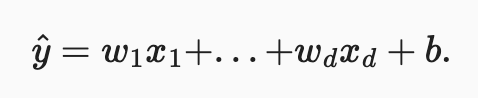

## 2. Loss Function : 

- Before we start thinking about how to fit data with our model, we need to determine a measure of fitness. The loss function quantifies the distance between the real and predicted value of the target.

- The loss will usually be a non-negative number where smaller values are better and perfect predictions incur a loss of 0. 

- The most popular loss function in regression problems is the squared error. SSR

## 3. Minibatch SGD 

- The key technique for optimizing nearly any deep learning model,consists of iteratively reducing the error by updating the parameters in the direction that incrementally lowers the loss function. This algorithm is called `gradient descent`.

- The most naive application of gradient descent consists of taking the derivative of the loss function, which is an average of the losses computed on every single example in the dataset.

- In practice, this can be extremely slow: we must pass over the entire dataset before making a single update.

### minibatch stochastic gradient descent : 

In each iteration, we first randomly sample a minibatch `B` consisting of a fixed number of training examples. We then compute the derivative (gradient) of the average loss on the minibatch with regard to the model parameters. Finally, we multiply the gradient by a predetermined positive value `eta` and subtract the resulting term from the current parameter values.

To summarize, steps of the algorithm are the following: 

- (i) we initialize the values of the model parameters, typically at random; 
- (ii) we iteratively sample random minibatches from the data, updating the parameters in the direction of the negative gradient.


### Making Predictions with the learned model 

Given the learned linear regression model, we can now estimate the price of a new house (not contained in the training data) given its area x1 and age x2. Estimating targets given features is commonly called prediction or inference.








## Vectorization for speed 

When training our models, we typically want to process whole minibatches of examples simultaneously. Doing this efficiently requires that we vectorize the calculations and leverage fast linear algebra libraries rather than writing costly for-loops in Python.

In [7]:
import math
import time
import numpy as np
import torch
import random

To illustrate why this matters so much, we can consider two methods for adding vectors. To start we instantiate two 10000-dimensional vectors containing all ones. In one method we will loop over the vectors with a Python for-loop. In the other method we will rely on a single call to +.

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


Now we can benchmark the workloads. First, we add them, one coordinate at a time, using a for-loop.

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.09873 sec'

Alternatively, we rely on the reloaded + operator to compute the elementwise sum.

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00133 sec'

You probably noticed that the second method is dramatically faster than the first.

The normal distribution and linear regression runs really well so, The probability density of a normal distribution with mean  and variance  (standard deviation ) is given as : 

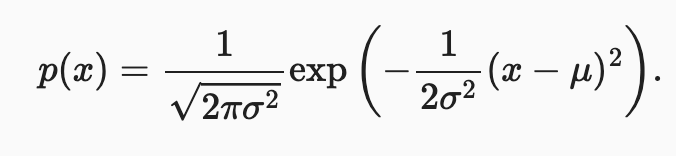



In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

## Implementation from scratch

In [8]:
# generating synthetic data 

def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that each row in features consists of a 2-dimensional data example and that each row in labels consists of a 1-dimensional label value (a scalar).

In [9]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.9585, 1.0293]) 
label: tensor([2.6068])


### Reading the Dataset

In [10]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [11]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3457, -1.3405],
        [ 0.6263,  0.4578],
        [ 1.0105, -0.7020],
        [ 0.2119, -1.1383],
        [-1.0163, -0.8974],
        [-1.3073, -1.5251],
        [-1.7682,  0.1358],
        [-0.3390,  0.7889],
        [ 0.5115, -0.6481],
        [-0.4468,  1.0233]]) 
 tensor([[ 9.4402],
        [ 3.8919],
        [ 8.6070],
        [ 8.4819],
        [ 5.2301],
        [ 6.7788],
        [ 0.1830],
        [ 0.8391],
        [ 7.4289],
        [-0.1821]])


### inintialize model parametrs 

Before we can begin optimizing our model’s parameters by minibatch stochastic gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

In [12]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

After initializing our parameters, our next task is to update them until they fit our data sufficiently well. Each update requires taking the gradient of our loss function with respect to the parameters. Given this gradient, we can update each parameter in the direction that may reduce the loss.

## Defining a model : 


In [13]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first.

We need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following function will also have the same shape as y_hat.

## Defining the loss function

In [14]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Defining optimization Algirithm

At each step, using one minibatch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss.

The following code applies the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.



In [15]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training : 

- Now that we have all of the parts in place, we are ready to implement the main training loop.

- In each iteration, we will grab a minibatch of training examples, and pass them through our model to obtain a set of predictions. 

- After calculating the loss, we initiate the backwards pass through the network, storing the gradients with respect to each parameter.

- Finally, we will call the optimization algorithm sgd to update the model parameters.

- In each epoch, we will iterate through the entire dataset (using the data_iter function) once passing through every example in the training dataset (assuming that the number of examples is divisible by the batch size).

- The number of epochs num_epochs and the learning rate lr are both hyperparameters, which we set here to 3 and 0.03, respectively. Unfortunately, setting hyperparameters is tricky and requires some adjustment by trial and error.

In [16]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033319
epoch 2, loss 0.000115
epoch 3, loss 0.000048


In this case, because we synthesized the dataset ourselves, we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

## Summary :
We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.

# Exercise :

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work?

2. Experiment using different learning rates to find out how fast the loss function value drops.